In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from fooof import FOOOF
from fooof.analysis import get_band_peak_fm
from analysis import plot # importing analysis module enables import from model folder
from build_input import get_stim_cycle, t_start, on_time, off_time
from IPython.display import clear_output
import statistics
import math

TRIAL_TYPES_list = ["baseline", "short", "long"] #list of types of runs
TRIAL_TYPES = np.array(TRIAL_TYPES_list)

TRIAL_START = 1 #when first set of trial starts
TRIAL_AMOUNTS = 10 #how many trials to average
RESULT_PATHS = []

bands = {'beta' : [13, 35],
        'gamma' : [35, 80]}


for TRIAL_TYPE in TRIAL_TYPES: #determines pathing based on 
    RESULT_PATH = "simulation_results_v2"   
    if 'short' in TRIAL_TYPE:
        RESULT_PATH +="/short"
    if 'long' in TRIAL_TYPE:
        RESULT_PATH +='/long'
    if 'baseline' in TRIAL_TYPE:
        RESULT_PATH +='/baseline'
    RESULT_PATHS.append(RESULT_PATH)
all_freq_list = [] #will hold a list of lists.
all_power_list = []
all_beta_list = []
all_gamma_list = []
for t,TRIAL_TYPE in enumerate(TRIAL_TYPES):
    RESULT_PATH = RESULT_PATHS[t]
    individual_freq_list = [] #list for individual types(baseline, long, short)
    individual_power_list = []
    individual_beta_list = []
    individual_gamma_list = []
    for i in range(TRIAL_AMOUNTS):
        TRIAL_NUM = str(TRIAL_START+i)

        TRIAL_NAME = TRIAL_TYPE + "_" + TRIAL_NUM
        
        TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)
        isbaseline = 'baseline' in TRIAL_NAME or 'const' in TRIAL_NAME
    
    
        elec_id = 0
        ecp_file = "ecp.h5"
        try:
            
            with h5py.File(os.path.join(TRIAL_PATH, ecp_file), 'r') as f:
                ecp = f['ecp']
                lfp = ecp['data'][:, elec_id]
                lfp -= np.mean(lfp)
                t = np.arange(*ecp['time'])
                fs = 1000 / ecp['time'][2] # sampling rate Hz
        
            if isbaseline:
                on_time, off_time = on_time + off_time, 0.0
            else:
            #     # if any correction needed
            #     t_start = 1.25  # sec. Time to start burst input
            #     on_time = 0.75  # sec. Burst input duration
            #     off_time = 0.75  # sec. Silence duration
                t_stop = t.size / fs
                t_cycle, n_cycle = get_stim_cycle(on_time, off_time, t_start, t_stop)
                window = t_start + np.array([[0, on_time]])
                windows = (window + t_cycle * np.arange(n_cycle).reshape(n_cycle, 1))

            tseg = 0.5
            f, pxx, stim_cycle = plot.get_psd_on_stimulus(
            lfp, fs, on_time, off_time, t_start, t=t, tseg=tseg)
            individual_freq_list.append(f)
            individual_power_list.append(pxx)
            
            results, fm = plot.fit_fooof(
            f, pxx, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
            freq_range=600., peak_width_limits=100., report=True,
            plot=False, plt_log=False, plt_range=100)
            
            beta = get_band_peak_fm(fm=fm, band=bands['beta'],select_highest=True)
            if math.isnan(beta[1]):
                beta[1] = 0 #changes nana to 0 because if there are no peaks, then the power is 0     
            gamma = get_band_peak_fm(fm=fm, band=bands['gamma'],select_highest=True)
            if math.isnan(gamma[1]):
                gamma[1] = 0 #changes nan to 0 because if there are no peaks, then the power is 0
            
            individual_beta_list.append(beta[1])
            individual_gamma_list.append(gamma[1])
            
            
        except:
            clear_output()
            print("There is no runs of " + TRIAL_TYPE)
        
    all_freq_list.append(individual_freq_list)
    all_power_list.append(individual_power_list)
    all_beta_list.append(individual_beta_list)
    all_gamma_list.append(individual_gamma_list)


  

/tmp/ipykernel_2547643/3131245490.py:5: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 600 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -6.0360, 1.2210                                          
                                                                                                  
                                       5 peaks were found:                                        
          

In [3]:
def mean_PSD(power): #takes average of power at very time step, but must be given a list
    power_list = []
    for step in range(len(power[0])):
        mean_power = 0
        count = 0
        for run in range(len(power)):
            mean_power+= (power[run])[step]
            count += 1
            
        mean_power /= count
        power_list.append(mean_power)
    return power_list

all_mean_freq = []
all_mean_power = []

for i in range(len(TRIAL_TYPES)): #averages out PSD for every type of run
    mean_freq = mean_PSD(all_freq_list[i])
    mean_power = mean_PSD(all_power_list[i])
    all_mean_freq.append(mean_freq)
    all_mean_power.append(mean_power)

/tmp/ipykernel_2547643/313534931.py:19: RuntimeWarning: invalid value encountered in scalar divide
  percentage_difference = ((B - A) / ((A + B) / 2)) * 100


'Short has nan% more beta power(at their respective center frequencies) than baseline'

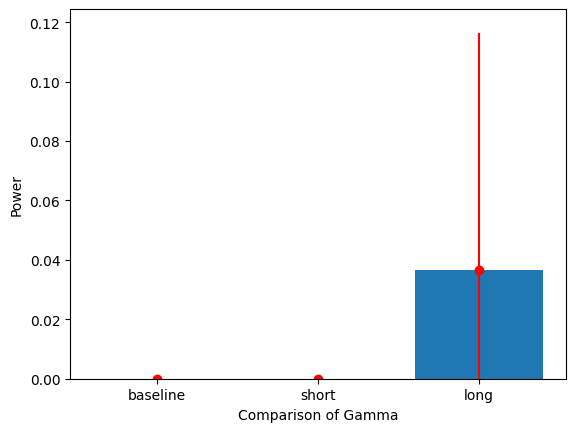

In [8]:
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display

plt_range = 100
plt_log=False




w_baseline = widgets.Button(description = 'Baseline', icon = 'history', button_style = 'primary')
w_short = widgets.Button(description = 'Short', icon = 'history', button_style = 'primary')
w_long = widgets.Button(description = 'Long', icon = 'history', button_style = 'primary')
w_gamma = widgets.Button(description = 'Compare Gamma', icon = 'history', button_style = 'primary')
w_beta = widgets.Button(description = 'Compare Beta', icon = 'history', button_style = 'primary')


def calculate_percentage_difference(A, B):
    percentage_difference = ((B - A) / ((A + B) / 2)) * 100
    return percentage_difference


def plot_baseline(*args):
    clear_output()
    display(ui)
    mean_freq = np.array(all_mean_freq[0])
    mean_power = np.array(all_mean_power[0])
    results, fm_baseline = plot.fit_fooof(
        mean_freq, mean_power, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
        freq_range=600., peak_width_limits=100., report=True,
        plot=True, plt_log=plt_log, plt_range=plt_range)
    _, ax = plt.subplots(1, 1, figsize=(8, 5))
    res_psd, res_fit = plot.psd_residual(
    mean_freq, mean_power, results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
    yl = plt.gca().get_ylim()
    plt.gca().set_ylim(bottom=max(yl[0], -yl[1]))
    plt.show()
w_baseline.on_click(plot_baseline)

def plot_short(*args):
    clear_output()
    display(ui)
    mean_freq = np.array(all_mean_freq[1])
    mean_power = np.array(all_mean_power[1])
    results, fm_short = plot.fit_fooof(
        mean_freq, mean_power, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
        freq_range=600., peak_width_limits=100., report=True,
        plot=True, plt_log=plt_log, plt_range=plt_range)
    _, ax = plt.subplots(1, 1, figsize=(8, 5))
    res_psd, res_fit = plot.psd_residual(
    mean_freq, mean_power, results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
    yl = plt.gca().get_ylim()
    plt.gca().set_ylim(bottom=max(yl[0], -yl[1]))
    plt.show()
w_short.on_click(plot_short)   
    
    
def plot_long(*args):
    clear_output()
    display(ui)
    mean_freq = np.array(all_mean_freq[2])
    mean_power = np.array(all_mean_power[2])
    results, fm_long = plot.fit_fooof(
        mean_freq, mean_power, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
        freq_range=600., peak_width_limits=100., report=True,
        plot=True, plt_log=plt_log, plt_range=plt_range)
    _, ax = plt.subplots(1, 1, figsize=(8, 5))
    res_psd, res_fit = plot.psd_residual(
    mean_freq, mean_power, results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
    yl = plt.gca().get_ylim()
    plt.gca().set_ylim(bottom=max(yl[0], -yl[1]))
    plt.show()
w_long.on_click(plot_long)
    
def compare_gamma(*args):
    clear_output()
    display(ui)
    baseline_gamma_mean = statistics.mean(all_gamma_list[0])
    baseline_gamma_std = statistics.stdev(all_gamma_list[0])
    short_gamma_mean = statistics.mean(all_gamma_list[1])
    short_gamma_std = statistics.stdev(all_gamma_list[1])
    long_gamma_mean = statistics.mean(all_gamma_list[2])
    long_gamma_std = statistics.stdev(all_gamma_list[2])
    
    
    #label = ["Baseline Gamma", "Short Gamma"]
    mean = [baseline_gamma_mean,short_gamma_mean,long_gamma_mean]
    std = [baseline_gamma_std,short_gamma_std,long_gamma_std]
    plt.bar(TRIAL_TYPES_list,mean)
    plt.errorbar(x=TRIAL_TYPES_list,y=mean, yerr=std, fmt="o", color="r")
    plt.ylim(bottom=0)
    plt.ylabel("Power")
    plt.xlabel("Comparison of Gamma")
    plt.plot()
    short_perc_diff = calculate_percentage_difference(baseline_gamma_mean,short_gamma_mean)
    display(f"Short has {perc_diff:.2f}% more beta power(at their respective center frequencies) than baseline")
    perc_diff = calculate_percentage_difference(baseline_gamma_mean,short_gamma_mean)
    display(f"Short has {perc_diff:.2f}% more beta power(at their respective center frequencies) than baseline")
    
w_gamma.on_click(compare_gamma)

def compare_beta(*args):
    clear_output()
    display(ui)
    baseline_beta_mean = statistics.mean(all_beta_list[0])
    baseline_beta_std = statistics.stdev(all_beta_list[0])
    short_beta_mean = statistics.mean(all_beta_list[1])
    short_beta_std = statistics.stdev(all_beta_list[1])
    long_beta_mean = statistics.mean(all_beta_list[2])
    long_beta_std = statistics.stdev(all_beta_list[2])
    
    #label = ["Baseline Beta", "Long Beta"]
    mean = [baseline_beta_mean,short_beta_mean,long_beta_mean]
    std = [baseline_beta_std,short_beta_std,long_beta_std]
    plt.bar(TRIAL_TYPES_list,mean)
    plt.errorbar(x=TRIAL_TYPES_list,y=mean, yerr=std, fmt="o", color="r")
    plt.ylabel("Power")
    plt.xlabel("Comparison of Beta")
    plt.plot()
w_beta.on_click(compare_beta)

ui = VBox([HBox([w_baseline,w_short,w_long]),HBox([w_gamma,w_beta])])
display(ui)